# This code visulize wight of Fiftywords dataset

# the training data might not have noise in some frequencies
    search "No noise in training data"
# The learned weight will keep those frequencies of noise from initial weight 
    search "Noise in learned weight"


In [1]:
import os
import sys
currentdir = os.path.dirname(os.path.abspath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from utils.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.OS_CNN import OS_CNN


# model saved in result log folder
Result_log_folder = parentdir+'/Results_of_OS_CNN/OS_CNN_result_iter_0/'
dataset_path = dirname(parentdir+"/Example_Datasets/UCRArchive_2018/")
dataset_name = 'FiftyWords'
#batch_size for test
batch_size = 16
print('test dataset:', dataset_name)

test dataset: FiftyWords


In [2]:
# load data
X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    
# put data to GPU
X_train = torch.from_numpy(X_train)
X_train.requires_grad = False
X_train = X_train.unsqueeze_(1).to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
X_test = X_test.unsqueeze_(1).to(device)
y_test = torch.from_numpy(y_test).to(device)
input_shape = X_train.shape[-1]
n_class = max(y_train) + 1
print('the size of inpute dataset is:',input_shape)
print('number of class is:',n_class)
    
    
#build dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

the size of inpute dataset is: 270
number of class is: tensor(50, device='cuda:0')


In [3]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train.shape)
print('the max size of kernel is:', receptive_field_shape*2)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)


the shape of inpute data is: torch.Size([450, 1, 270])
the max size of kernel is: 134
the Network structure for FiftyWords is:
[[(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 5), (1, 1, 7), (1, 1, 11), (1, 1, 13), (1, 1, 17), (1, 1, 19), (1, 1, 23), (1, 1, 29), (1, 1, 31), (1, 1, 37), (1, 1, 41), (1, 1, 43), (1, 1, 47), (1, 1, 53), (1, 1, 59), (1, 1, 61), (1, 1, 67)], [(20, 20, 1), (20, 20, 2), (20, 20, 3), (20, 20, 5), (20, 20, 7), (20, 20, 11), (20, 20, 13), (20, 20, 17), (20, 20, 19), (20, 20, 23), (20, 20, 29), (20, 20, 31), (20, 20, 37), (20, 20, 41), (20, 20, 43), (20, 20, 47), (20, 20, 53), (20, 20, 59), (20, 20, 61), (20, 20, 67)], [(400, 20, 1), (400, 20, 2)]]


In [4]:
# find model path
best_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'
initial_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'initial_model'
# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))


torch_FCN_initial = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN_initial.load_state_dict(torch.load(initial_model_path, map_location=device))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
import matplotlib.pyplot as plt
def get_a_conv(i,j,torch_FCN, channel = 0):
    # i is the ith layer
    # j is the jth conv
    return torch_FCN.net[i-1].conv_list[j-1].conv1d

def get_channel_number_in_layer(i,layer_parameter_list):
    #i is the ith layer
    return layer_parameter_list[i-1][0][1]

def get_zero_padding_to_weight(weight,expecd_length):
    white_base = np.zeros((expecd_length))
    white_base[0:len(weight)] = weight
    
    return white_base


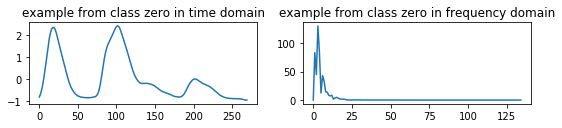

In [14]:
###############
# No noise in training data
##############

def select_certain_class(The_class_we_want, X_train,y_train):
    selected_train = X_train[y_train == The_class_we_want]
    return selected_train



# view one example
temp = np.squeeze(select_certain_class(0, X_train,y_train).cpu().detach().numpy(), 1)
example = temp[0]

plt.figure(figsize=(9, 1.5)) 
plt.subplot(1, 2, 1)
plt.title('example from class zero in time domain')
plt.plot(example)
plt.subplot(1, 2, 2)
plt.title('example from class zero in frequency domain')
plt.plot(abs(np.fft.fft(example))[0:int(len(example)/2)])



## view all class
# for i in range(n_class):
#     plt.figure()
#     plt.title('Class'+str(i))
#     temp = np.squeeze(select_certain_class(i, X_train,y_train).cpu().detach().numpy(), 1)
#     for j in range(temp.shape[0]):
#         plt.plot(temp[j])



Visualize each channel of 2 th layer's 20 th kernel, the length of kernel is 67


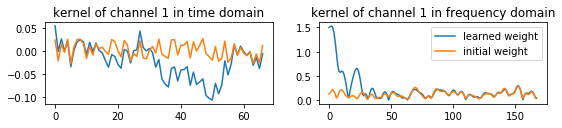

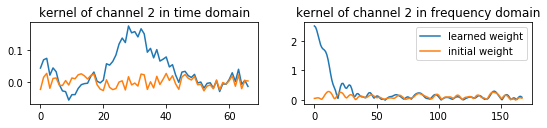

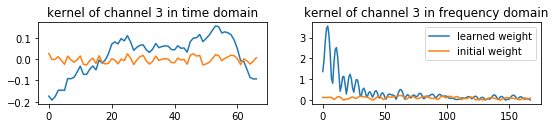

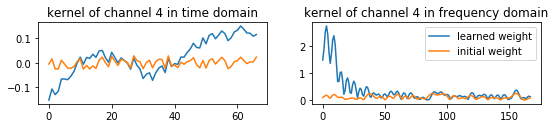

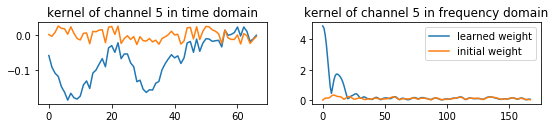

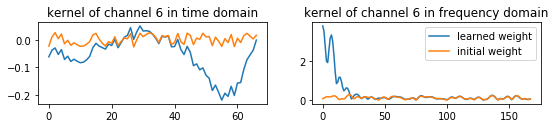

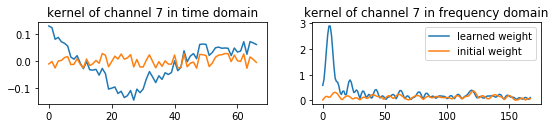

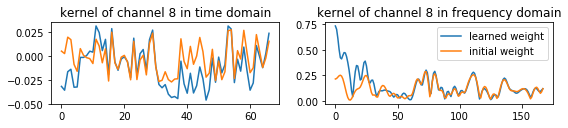

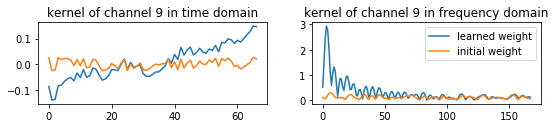

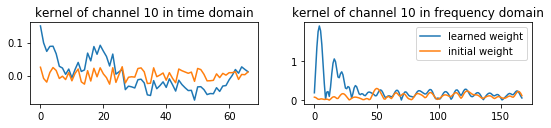

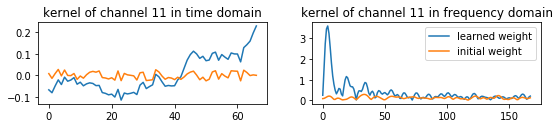

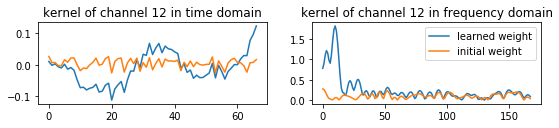

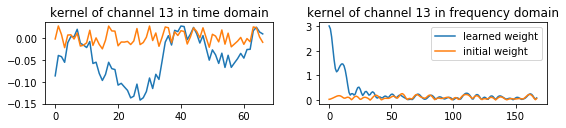

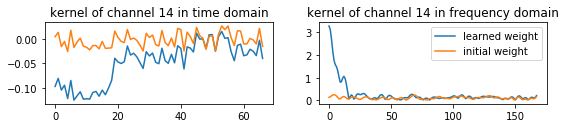

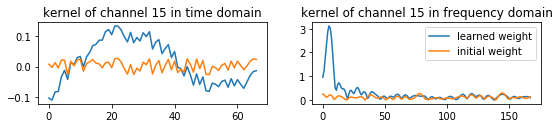

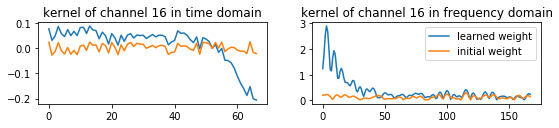

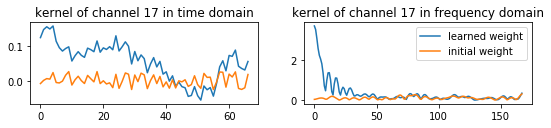

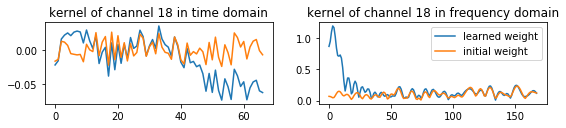

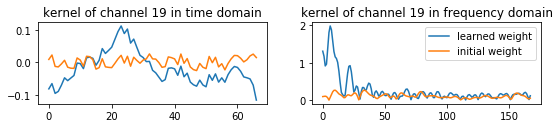

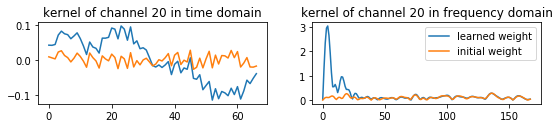

In [12]:
###############
# Noise in learned weight
##############
jth_kernel = len(layer_parameter_list[0])
ith_layer = 2
print('Visualize each channel of',str(ith_layer),'th layer\'s',str(jth_kernel),'th kernel, the length of kernel is',str(layer_parameter_list[0][jth_kernel-1][-1]))
for c in range(get_channel_number_in_layer(ith_layer,layer_parameter_list)):
    weight = get_a_conv(ith_layer,jth_kernel,torch_FCN).weight.cpu().detach().numpy()[c,1,:]
    zeropadding_weight = get_zero_padding_to_weight(weight,X_train.shape[2]+len(weight))
    
    weight_initial = get_a_conv(ith_layer,jth_kernel,torch_FCN_initial).weight.cpu().detach().numpy()[c,1,:]
    zeropadding_weight_initial = get_zero_padding_to_weight(weight_initial,X_train.shape[2]+len(weight_initial))
    
    plt.figure(figsize=(9, 1.5)) 
    plt.subplot(1, 2, 1)
    plt.title('kernel of channel '+str(c+1)+' in time domain')
    plt.plot(weight,label="learned weight")
    plt.plot(weight_initial,label="initial weight")
    plt.subplot(1, 2, 2)
    plt.title('kernel of channel '+str(c+1)+' in frequency domain')
    plt.plot(abs(np.fft.fft(zeropadding_weight))[0:int((X_train.shape[2]+len(weight))/2)],label="learned weight")
    plt.plot(abs(np.fft.fft(zeropadding_weight_initial))[0:int((X_train.shape[2]+len(weight_initial))/2)],label="initial weight")
    plt.legend(loc="upper right")


# The above image is highly overlap on hight frequencies which is zero in training datasets 